In [1]:
# params
import psycopg2
import pandas as pd
from datetime import datetime, timedelta
import warnings
import numpy as np
import pytz
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")

tz = pytz.timezone('America/New_York')
da = datetime.now(tz).strftime("%Y-%m-%d")
da = '2024-09-24'
# da = '2024-09-09'

                    0    1       2
0 2024-09-23 10:22:00  DIA  421.17
1 2024-09-23 10:22:00  VOO  525.32
2 2024-09-23 10:22:00  QQQ  483.22
3 2024-09-23 10:21:00  QQQ  483.03
4 2024-09-23 10:21:00  VOO  525.22


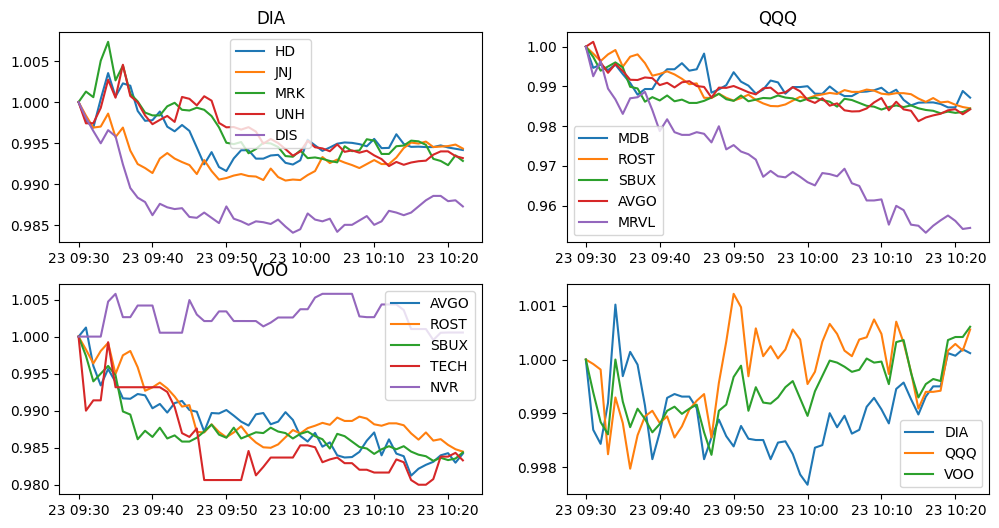

In [31]:
# combined; this only
DB_HOST = 'localhost'
DB_NAME = 'us'
DB_USER = 'postgres'
DB_PASS = 'buddyrich134'
def get_db_connection():
    conn = psycopg2.connect(host=DB_HOST, dbname=DB_NAME, user=DB_USER, password=DB_PASS)
    return conn
conn = get_db_connection()
cursor = conn.cursor()
limit = 59
ti = 10
def signal_generator_30(index_name='us30', benchmark="DIA"):
    try:
        cursor.execute(f"SELECT distinct code from public.maincode where listed = '{index_name}';")
        conn.commit()
        list_ = [i[0] for i in cursor.fetchall()]

        list_str = ','.join([f"'{i}'" for i in list_]) #  and da <= '{da} {ti}:{limit}:00'
        cursor.execute(f"SELECT da, code, op from public.stock_price_5m where code in ({list_str}) and da >= '{da} 09:30:00' and da <= '{da} {ti}:{limit}:00' order by da asc;")
        conn.commit()
        res = cursor.fetchall()
        df = pd.DataFrame(res)
        df.columns = ['da','code', 'op']
        pivoted = df.pivot(columns='code', values='op', index='da')
        pivoted.ffill()

        dft = pd.DataFrame()
        dft['percent'] = np.round((pivoted.iloc[-1, :] / pivoted.iloc[0, :]) - 1, 3)
        dft['price'] = pivoted.iloc[-1, :]
        dft = dft[dft['price'] >= 50]
        dft = dft.sort_values(by='percent', ascending=False)
        if (pivoted[benchmark].iloc[-1] / pivoted[benchmark].iloc[0]) - 1 > 0:
            t = dft.tail()
        else:
            t = dft.head()
        return (1 + pivoted[list(t.index)].pct_change().fillna(0)).cumprod()
    except:
        return None

cursor.execute(f"SELECT da, code, op from public.stock_price_5m where code in ('VOO', 'DIA', 'QQQ') and da >= '{da} 09:30:00' and da <= '{da} {ti}:{limit}:00'order by da desc;")
conn.commit()
res = cursor.fetchall()
df = pd.DataFrame(res)
print(df.head())
df.columns = ['da','code', 'op']
pivoted = df.pivot(columns='code', values='op', index='da')
pivoted.ffill()
ret = (1 + pivoted.pct_change().fillna(0)).cumprod()

fig, ax = plt.subplots(2, 2, figsize=(12, 6))
a = signal_generator_30()
ax[0, 0].plot(a, label=a.columns)
ax[0, 0].legend(a.columns)
ax[0, 0].set_title('DIA')

a = signal_generator_30('us100', 'QQQ')
ax[0, 1].plot(a, label=a.columns)
ax[0, 1].legend(a.columns)
ax[0, 1].set_title('QQQ')

a = signal_generator_30('us500', 'VOO')
ax[1, 0].plot(a, label=a.columns)
ax[1, 0].legend(a.columns)
ax[1, 0].set_title('VOO')

ax[1, 1].plot(ret, label=ret.columns)
ax[1, 1].legend(ret.columns)

plt.show()

<Axes: xlabel='code'>

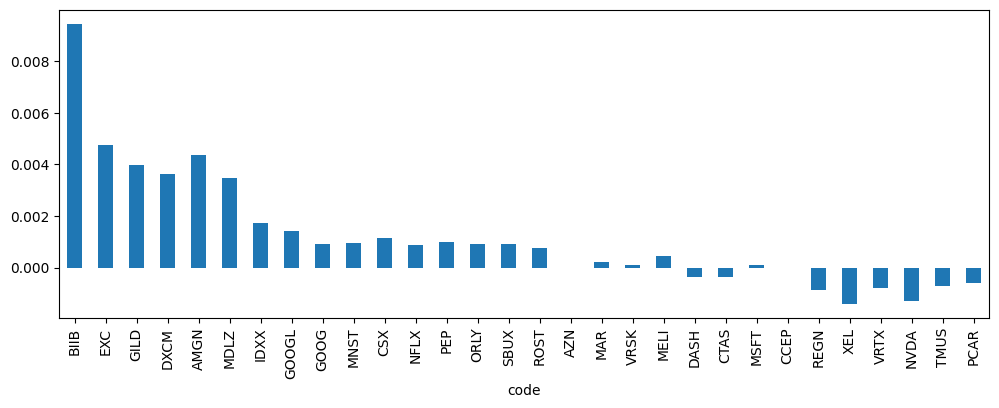

In [55]:
# us100
DB_HOST = 'localhost'
DB_NAME = 'us'
DB_USER = 'postgres'
DB_PASS = 'buddyrich134'
def get_db_connection():
    conn = psycopg2.connect(host=DB_HOST, dbname=DB_NAME, user=DB_USER, password=DB_PASS)
    return conn

type_ = 'us100'
index_bm = 'QQQ' if type_ == 'us100' else 'DIA'
conn = get_db_connection()
cursor = conn.cursor()

cursor.execute(f"SELECT distinct code from public.maincode where listed = '{type_}';")
conn.commit()
list_ = [i[0] for i in cursor.fetchall()]

list_str = ','.join([f"'{i}'" for i in list_])
cursor.execute(f"SELECT da, code, cl from public.stock_price_5m where code in ({list_str}) and da >= '{da} 09:40:00' and da <= '{da} 09:59:00' order by da desc;")
conn.commit()
res = cursor.fetchall()
df = pd.DataFrame(res)
df.columns = ['da','code', 'cl']
pivoted = df.pivot(columns='code', values='cl', index='da')
pivoted.ffill()

dft = pd.DataFrame()
dft['percent'] = np.round((pivoted.iloc[-1, :] / pivoted.iloc[0, :]) - 1, 3)
dft['price'] = pivoted.iloc[-1, :]

dft = dft.sort_values(by='percent', ascending=False)
if (pivoted[index_bm].iloc[-1] / pivoted[index_bm].iloc[0]) - 1 > 0:
    # print(pivoted.index[-1], '\n', dft.tail(), '\n', (pivoted[index_bm].iloc[-1] / pivoted[index_bm].iloc[0]) - 1)
    t = dft
else:
    t = dft
# print(pivoted.index[-1], '\n', dft.head(), '\n', (pivoted[index_bm].iloc[-1] / pivoted[index_bm].iloc[0]) - 1)
((1 + pivoted[list(t.index)].pct_change().fillna(0)).cumprod().iloc[-1, :30]-1).plot(figsize=(12, 4), kind='bar')

In [56]:
# us30
DB_HOST = 'localhost'
DB_NAME = 'us'
DB_USER = 'postgres'
DB_PASS = 'buddyrich134'
def get_db_connection():
    conn = psycopg2.connect(host=DB_HOST, dbname=DB_NAME, user=DB_USER, password=DB_PASS)
    return conn


conn = get_db_connection()
cursor = conn.cursor()

cursor.execute(f"SELECT distinct code from public.maincode where listed = 'us30';")
conn.commit()
list_ = [i[0] for i in cursor.fetchall()]

list_str = ','.join([f"'{i}'" for i in list_])
cursor.execute(f"SELECT da, code, cl from public.stock_price where code in ({list_str}) and da >= '{da} 09:30:00' and da <= '{da} 09:45:00' order by da desc;")
conn.commit()
res = cursor.fetchall()
df = pd.DataFrame(res)
df.columns = ['da','code', 'cl']
pivoted = df.pivot(columns='code', values='cl', index='da')
pivoted.ffill()

dft = pd.DataFrame()
dft['percent'] = np.round((pivoted.iloc[-1, :] / pivoted.iloc[0, :]) - 1, 3)
dft['price'] = pivoted.iloc[-1, :]
dft = dft.sort_values(by='percent', ascending=False)
if (pivoted['DIA'].iloc[-1] / pivoted['DIA'].iloc[0]) - 1 > 0:
    (1 + pivoted[list(dft.tail().index)].pct_change().fillna(0)).cumprod().plot(figsize=(12, 4))
else:
    (1 + pivoted[list(dft.head().index)].pct_change().fillna(0)).cumprod().plot(figsize=(12, 4))

print(pivoted.index[-1], '\n', dft.tail(), '\n', (pivoted['DIA'].iloc[-1] / pivoted['DIA'].iloc[0]) - 1)
print(pivoted.index[-1], '\n', dft.head(), '\n', (pivoted['DIA'].iloc[-1] / pivoted['DIA'].iloc[0]) - 1)

ValueError: Length mismatch: Expected axis has 0 elements, new values have 3 elements

In [ ]:
# us500
DB_HOST = 'localhost'
DB_NAME = 'us'
DB_USER = 'postgres'
DB_PASS = 'buddyrich134'
def get_db_connection():
    conn = psycopg2.connect(host=DB_HOST, dbname=DB_NAME, user=DB_USER, password=DB_PASS)
    return conn


conn = get_db_connection()
cursor = conn.cursor()

cursor.execute(f"SELECT distinct code from public.maincode where listed = 'us500';")
conn.commit()
list_ = [i[0] for i in cursor.fetchall()]

list_str = ','.join([f"'{i}'" for i in list_])
cursor.execute(f"SELECT da, code, cl from public.stock_price where code in ({list_str}) and da >= '{da} 09:30:00' and da <= '{da} 09:45:00' order by da desc;")
conn.commit()
res = cursor.fetchall()
df = pd.DataFrame(res)
df.columns = ['da','code', 'cl']
pivoted = df.pivot(columns='code', values='cl', index='da')
pivoted.ffill()

dft = pd.DataFrame()
dft['percent'] = np.round((pivoted.iloc[-1, :] / pivoted.iloc[0, :]) - 1, 3)
dft['price'] = pivoted.iloc[-1, :]
dft = dft.sort_values(by='percent', ascending=False)
if (pivoted['VOO'].iloc[-1] / pivoted['VOO'].iloc[0]) - 1 > 0:
    (1 + pivoted[list(dft.tail().index)].pct_change().fillna(0)).cumprod().plot(figsize=(12, 4))
else:
    (1 + pivoted[list(dft.head().index)].pct_change().fillna(0)).cumprod().plot(figsize=(12, 4))

print(pivoted.index[-1], '\n', dft.tail(), '\n', (pivoted['VOO'].iloc[-1] / pivoted['VOO'].iloc[0]) - 1)
print(pivoted.index[-1], '\n', dft.head(), '\n', (pivoted['VOO'].iloc[-1] / pivoted['VOO'].iloc[0]) - 1)

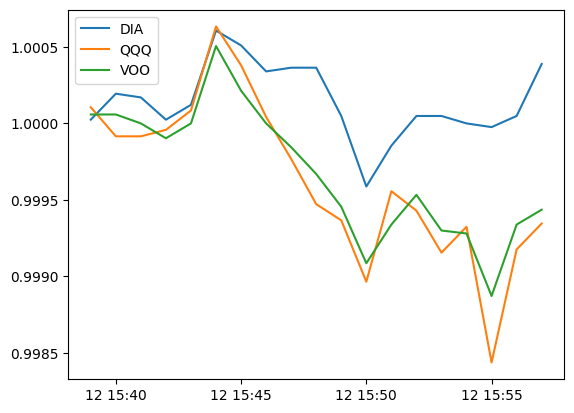

In [ ]:
# indice
DB_HOST = 'localhost'
DB_NAME = 'us'
DB_USER = 'postgres'
DB_PASS = 'buddyrich134'
def get_db_connection():
    conn = psycopg2.connect(host=DB_HOST, dbname=DB_NAME, user=DB_USER, password=DB_PASS)
    return conn


conn = get_db_connection()
cursor = conn.cursor()

cursor.execute(f"SELECT da, code, op from public.stock_price_5m where code in ('VOO', 'DIA', 'QQQ') and da >= '{da} 09:30:00' order by da desc limit 60;")
conn.commit()
res = cursor.fetchall()
df = pd.DataFrame(res)
df.columns = ['da','code', 'cl']
pivoted = df.pivot(columns='code', values='cl', index='da')
pivoted.ffill()
ret = (1 + pivoted.pct_change()).cumprod()
import matplotlib.pyplot as plt
plt.plot(ret, label=ret.columns)
plt.legend()
plt.savefig('test.png')

In [ ]:
# # backtest us500
# import psycopg2
# import pandas as pd
# from datetime import datetime, timedelta
# import warnings
# import numpy as np
# import pytz
# warnings.filterwarnings("ignore")

# tz = pytz.timezone('America/New_York')
# da = datetime.now(tz).strftime("%Y-%m-%d")
# da = '2024-09-09'
# DB_HOST = 'localhost'
# DB_NAME = 'us'
# DB_USER = 'postgres'
# DB_PASS = 'buddyrich134'
# def get_db_connection():
#     conn = psycopg2.connect(host=DB_HOST, dbname=DB_NAME, user=DB_USER, password=DB_PASS)
#     return conn


# conn = get_db_connection()
# cursor = conn.cursor()

# cursor.execute(f"SELECT distinct code from public.maincode where listed = 'us500';")
# conn.commit()
# list_ = [i[0] for i in cursor.fetchall()]

# import yfinance as yf
# from tqdm import tqdm
# dfs = []
# for code in tqdm(list_):
#     cl = yf.download(code, interval='1m', progress=False, ignore_tz=True, rounding=2)[['Open']]
#     cl.columns = [code]
#     dfs.append(cl)

# a = pd.concat(dfs, axis=1).sort_index(ascending=True).ffill()
# a['day'] = a.index.astype(str)
# a['day'] = a['day'].apply(lambda x: x[8:10])
# a['minute'] = a.index.astype(str)
# a['minute'] = a['minute'].apply(lambda x: int(x[-5:-3]))
# for k, q in a.groupby('day'):
#     subdf = q.iloc[:12, :-2]
#     dft = pd.DataFrame()
#     dft['percent'] = np.round((subdf.iloc[-1, :] / subdf.iloc[0, :]) - 1, 3)
#     dft['price'] = subdf.iloc[-1, :]
#     final = dft.sort_values(by='percent').dropna()
#     final = final[final['price'] > 50]
#     if (subdf['VOO'].iloc[-1] / subdf['VOO'].iloc[0]) - 1 > 0:

#         print(subdf.index[-1], '\n', final.iloc[:5, :], '\n', (subdf['VOO'].iloc[-1] / subdf['VOO'].iloc[0]) - 1)
#     else:
#         # print(subdf.index[-1], '\n', final.iloc[:5, :], '\n', final.iloc[-5:, :], '\n', )
#         print(subdf.index[-1], '\n', final.iloc[-5:, :], '\n', (subdf['VOO'].iloc[-1] / subdf['VOO'].iloc[0]) - 1)

#     print('========')